In [2]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import wandb


### Fashion Mnist Dataset

In [3]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()

### Question 1

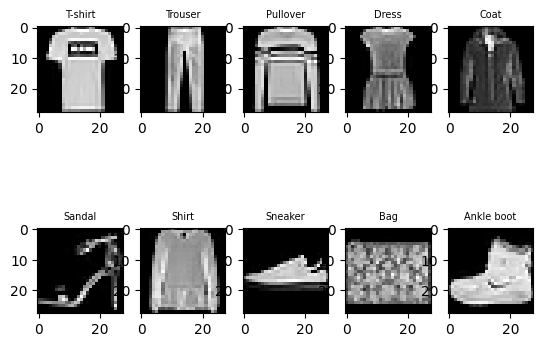

In [4]:
num_classes = len(np.unique(Y))
# for i in range(num_classes):
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["T-shirt", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1], cmap=plt.get_cmap('gray'))
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [5]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T


Size of Training DataSet = 48000
Size of Validation DataSet = 12000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Question 2

In [6]:
output_layer_nodes = num_classes
input_layer_nodes = num_features
# num_hidden_layers = 10

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-np.tanh(x)**2

def der_relu(x):
    return (x>0)*np.ones(x.shape)

def softmax(x):
    return (np.exp(x)/np.exp(x).sum())

def der_softmax(x):
    return softmax(x) * (1-softmax(x))

### Hidden Layer


In [8]:
class hidden_layer:
    '''
        num_neurons : number of neurons in the layer
        dim_in_layer : in_layer dimensions
        dim_out_layer : outLayer dimensions
        W : Weights
        b : Biases
        grad_W : gradient of weights
        grad_B : gradient of biases
    '''
    def __init__(self,num_neurons,dim_in_layer,dim_out_layer = -1):
        self.weight_initializers = {"random": self.random_initialization, "Xavier": self.xavier_intialization}
        self.num_neurons = num_neurons
        # self.dimension = num_features
        self.dim_in_layer = dim_in_layer
        self.dim_out_layer = dim_out_layer
        
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)*0.01

    def xavier_intialization(self, in_layer, out_layer):
        return np.random.normal(0, np.sqrt(2 / (in_layer + out_layer)), size=(in_layer, out_layer))
    
    def initialize_layer(self,initializer):
        N = self.num_neurons
        self.W = self.weight_initializers[initializer](in_layer = self.dim_in_layer,out_layer = N)
        self.b = np.zeros(shape=(N))#.reshape((N,1))
        self.a = np.zeros(shape= (N))
        self.h = np.zeros(shape=(self.dim_in_layer))
        
        self.grad_W = self.weight_initializers[initializer](in_layer = self.dim_in_layer,out_layer = N)
        self.grad_b = np.zeros(shape=(N))#.reshape((N,1))
        self.grad_a = np.zeros(shape= (N))
        self.grad_h = np.zeros(shape=(self.dim_in_layer))
        
        self.u_mgd_W = np.zeros(shape=(self.dim_in_layer,N))
        self.u_mgd_b = np.zeros(shape=(N))#.reshape((N,1))
        
        
        
        self.m_W = np.zeros(shape=(self.dim_in_layer,N))
        self.m_b = np.zeros(shape=(N))#.reshape((N,1))

### Feedforward Neural Network

In [16]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nestrov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all hidden layer 
        weight_Decay : 
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        beta : momentum
        beta1 : adam
        beta2 : adam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                #  weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 output_activation = softmax,
                 der_output_activation = der_softmax,
                 beta=0.9,
                 epsilon=1e-5,
                 beta1=0.9,
                 beta2=0.9):
        self.weight_initializer = weight_initializer
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nestrov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.output_activation = output_activation
        self.der_output_activation = der_output_activation
        # self.weight_Decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # return self
    
    def sgd(self,X,Y):
        # print("fromsgd")
        # print("Entered")
        self.ForwardPropagation(X)
        # print("from sgd Forward done")
        # print(Y.shape)
        self.BackPropagation(self.output_layer.h,Y,X)
        # print("from sgd Back done")
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            # print(L[i].b.shape,L[i].grad_b.shape)
            L[i].W = L[i].W - self.learning_rate*L[i].grad_W
            L[i].b = L[i].b - self.learning_rate*L[i].grad_b
        self.output_layer.W = self.output_layer.W - self.learning_rate*self.output_layer.grad_W
        self.output_layer.b = self.output_layer.b - self.learning_rate*self.output_layer.grad_b
        
    def nestrov(self,X,Y):
        pass
    
    def momentum(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = self.beta*L[i].u_mgd_W + L[i].grad_W
            L[i].u_mgd_b = self.beta*L[i].u_mgd_b + L[i].grad_b
            L[i].W = L[i].W - self.learning_rate*L[i].u_mgd_W
            L[i].b = L[i].b - self.learning_rate*L[i].u_mgd_b
        self.output_layer.u_mgd_W = self.beta*self.output_layer.u_mgd_W + self.output_layer.grad_W
        self.output_layer.u_mgd_b = self.beta*self.output_layer.u_mgd_b + self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - self.learning_rate*self.output_layer.u_mgd_W
        self.output_layer.b = self.output_layer.b - self.learning_rate*self.output_layer.u_mgd_b
        pass
    
    def rmsprop(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta = self.beta
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = beta*L[i].u_mgd_W + (1-beta)*L[i].grad_W
            L[i].u_mgd_b = beta*L[i].u_mgd_b + (1-beta)*L[i].grad_b
            L[i].W = L[i].W - (self.learning_rate*L[i].grad_W/(np.sqrt(L[i].u_mgd_W+self.epsilon)))
            L[i].b = L[i].b - (self.learning_rate*L[i].grad_b/(np.sqrt(L[i].u_mgd_b+self.epsilon)))
        self.output_layer.u_mgd_W = beta*self.output_layer.u_mgd_W + (1-beta)*self.output_layer.grad_W
        self.output_layer.u_mgd_b = beta*self.output_layer.u_mgd_b + (1-beta)*self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - (self.learning_rate*self.output_layer.grad_W/(np.sqrt(self.output_layer.u_mgd_W+self.epsilon)))
        self.output_layer.b = self.output_layer.b - (self.learning_rate*self.output_layer.grad_b/(np.sqrt(self.output_layer.u_mgd_b+self.epsilon)))
        pass
    
    def adam(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (self.learning_rate*m_hat_W/(np.sqrt(u_hat_W)+self.epsilon))
            L[i].b = L[i].b - (self.learning_rate*m_hat_b/(np.sqrt(u_hat_b)+self.epsilon))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (self.learning_rate*m_hat_W/(np.sqrt(u_hat_W)+self.epsilon))
        output.b = output.b - (self.learning_rate*m_hat_b/(np.sqrt(u_hat_b)+self.epsilon))
            
        pass
    def nadam(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (self.learning_rate/(np.sqrt(u_hat_W+self.epsilon)))*(beta1*m_hat_W+(1-beta1)*L[i].grad_W/(1-beta1**(i+1)))
            L[i].b = L[i].b - (self.learning_rate/(np.sqrt(u_hat_b+self.epsilon)))*(beta1*m_hat_b+(1-beta1)*L[i].grad_b/(1-beta1**(i+1)))
            # (eta/np.sqrt(v_w_hat+eps))* (beta1*m_w_hat+(1-beta1)*dw/(1-beta1**(i+1)))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (self.learning_rate/(np.sqrt(u_hat_W+self.epsilon)))*(beta1*m_hat_W+(1-beta1)*output.grad_W/(1-beta1**(i+1)))
        output.b = output.b - (self.learning_rate/(np.sqrt(u_hat_b+self.epsilon)))*(beta1*m_hat_b+(1-beta1)*output.grad_b/(1-beta1**(i+1)))
        pass
    
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])
    
    def initialize_hidden_layers(self):
        L = []
        in_layer, out_layer = num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
                
            L.append(hidden_layer(self.hidden_layer_dims[i],in_layer,out_layer))
            
        self.hidden_layers = np.array(L)
        self.output_layer = hidden_layer(self.output_layer_dim,self.hidden_layer_dims[self.num_hidden_layers-1],-1)
        
    def sanitize_Y(self):
        temp = np.zeros((num_classes,self.Y_train.shape[0]))
        for i in self.Y_train:
            temp[i][:] = 1
        self.Y_train = temp
        
        temp = np.zeros((num_classes,self.Yv.shape[0]))
        for i in self.Yv:
            temp[i][:] = 1
        self.Yv = temp
        
        pass
    
    def initialize_NeuralNet(self):
        for i in range(self.num_hidden_layers):
            self.hidden_layers[i].initialize_layer(self.weight_initializer)
        self.output_layer.initialize_layer(self.weight_initializer)
        self.sanitize_Y()
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            temp = np.zeros((L[i].W.shape[1],self.batch_size)).T
            temp[:],L[i].b = L[i].b,temp.T
            L[i].u_mgd_b = np.zeros(shape=L[i].b.shape)
            L[i].m_b = np.zeros(shape=L[i].b.shape)
        temp = np.zeros((self.output_layer.W.shape[1],self.batch_size)).T
        temp[:],self.output_layer.b = self.output_layer.b,temp.T
        self.output_layer.u_mgd_b = np.zeros(shape=self.output_layer.b.shape)
        self.output_layer.m_b = np.zeros(shape=self.output_layer.b.shape)
        pass
    
    def add_hidden(self,num_neurons):
        self.hidden_layer_dims.append(num_neurons)
        self.num_hidden_layers += 1
        # self.initialize_hidden_layers()
        # self.initialize_NeuralNet()
        pass
    
    def ForwardPropagation(self,X):
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            # print(L[i].W.shape)
            # print("1")
            if i==0:
                # print(L[i].W.shape,X.shape,L[i].b.shape)
                # L[i].a = L[i].b.reshape(L[i].b.shape[0],1) + np.matmul(np.transpose(L[i].W),X)
                # print(L[i].b.shape)
                # temp = np.zeros((L[i].W.shape[1],X.shape[1])).T
                # print(temp.shape)
                
                # temp[:],L[i].b = L[i].b,temp.T
                # print(temp.shape,L[i].b.shape)
                # print("W : ",L[i].W.shape,X.shape)
                L[i].a = L[i].b + np.matmul(np.transpose(L[i].W),X)
            else:
                # print(L[i].W.shape,L[i-1].h.shape,L[i].b.shape)
                # print(L[i].b.shape)
                # temp = np.zeros((L[i].W.shape[1],L[i-1].h.shape[1])).T
                # # print(temp.shape)
                # temp[:],L[i].b = L[i].b,temp.T
                # print(temp.shape,L[i].b.shape)
                L[i].a = L[i].b + np.matmul(np.transpose(L[i].W),L[i-1].h)
            # print("2")
            L[i].h = self.activation(L[i].a)
        # print(np.transpose(self.output_layer.W).shape)
        # print(L.shape)
        # print(self.num_hidden_layers)
        # ti = L[num_hidden_layers-1]
        # print(L[num_hidden_layers-1].h.shape)
        # print("done")
        # temp = np.zeros((self.output_layer.W.shape[1],L[self.num_hidden_layers-1].h.shape[1])).T
        # # print(self.output_layer.b.shape)
        # # print(temp.shape)
        # temp[:],self.output_layer.b = self.output_layer.b,temp.T
        self.output_layer.a = self.output_layer.b + np.matmul(np.transpose(self.output_layer.W),L[self.num_hidden_layers-1].h)
        self.output_layer.h = self.output_activation(self.output_layer.a)
        pass
    
    def BackPropagation(self,y_hat,y,X):
        L = self.hidden_layers
        N = self.num_hidden_layers
        # print(y_hat.shape,y.shape)
        # self.output_layer.grad_a = y_hat - np.eye(num_classes)[y]
        out_layer = self.output_layer
        out_layer.grad_a = y_hat - y
        # for the output layer
        # print("here",L[N-1].h.shape)
        # print("1")
        # out_layer.grad_W = np.matmul(out_layer.grad_a,np.transpose(L[N-1].h))
        # print(out_layer.grad_a.shape,L[N-1].h.shape)
        out_layer.grad_W = np.matmul(out_layer.grad_a,np.transpose(L[N-1].h)).T
        # print(out_layer.grad_W.shape,out_layer.W.shape)
        # print("2")
        out_layer.grad_b = out_layer.grad_a
        # print("3")
        # print(out_layer)
        # print(out_layer.grad_h.shape)
        # print(out_layer.W.shape,out_layer.grad_a.shape)
        L[N-1].grad_h = np.matmul(out_layer.W,out_layer.grad_a)
        # print("4")
        L[N-1].grad_a = L[N-1].h * self.der_output_activation(L[N-1].a)
        # print("5")
        for i in np.flip(np.arange(N)):
            if(i!=0):
                L[i].grad_W = np.matmul(L[i].grad_a,np.transpose(L[i-1].h)).T
            else:
                L[i].grad_W = np.matmul(L[i].grad_a,np.transpose(X)).T
            
            L[i].grad_b = L[i].grad_a
            # print(i)
            # if i>0:
            #     L[i-1].grad_h = np.matmul(L[i].W,L[i].grad_a)
            #     # print(self.activation)
            #     # print(self.der_activation_functions)
            #     L[i-1].grad_a = L[i-1].h * self.activation(L[i-1].a)
            # print(L[-2])
            L[i-1].grad_h = np.matmul(L[i].W,L[i].grad_a)
            L[i-1].grad_a = L[i-1].h * self.activation(L[i-1].a)
        
        pass
        
    
    def fit_NeuralNet(self):
        self.initialize_hidden_layers()
        self.initialize_NeuralNet()
        # self.cost_per_epoch = np.zeros(self.num_epochs)
        # print(self.Y_train.shape)
        for curr_epoch in range(self.num_epochs):
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(self.X_train.shape[1]-i,self.batch_size)
                # print(self.optimizer)
                # print(i,i+curr_batch-1)
                # print(self.X_train[:,i:i+curr_batch].shape)
                
                # if(curr_batch < self.batch_size):
                #     self.optimizer(self.X_train[:,i:i+curr_batch].T.resize(self.batch_size,X_train.shape[0].T),self.Y_train[:,i:i+curr_batch].T.resize(self.batch_size,Y_train.shape[0].T))
                # else:
                #     self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
                self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
                # print("done")
            
                
        pass
    
    def print_all(self):
        # print("weight_initializer = ",self.weight_initializer)
        # print("activation_functions = ",self.activation_functions)
        # print("optimizer_functions = ",self.optimizer_functions)
        # print("weight_initializers = ",self.weight_initializers)
        # print("activation = ",self.activation)
        # print("optimizer = ",self.optimizer)
        # print("learning_rate = ",self.learning_rate)
        # print("batch_size = ",self.batch_size)
        # print("num_epochs = ",self.num_epochs)
        # print("num_hidden_layers = ",self.num_hidden_layers)
        # print("output_layer_dim = ",self.output_layer_dim)
        # print("hidden_layer_dims = ",self.hidden_layer_dims)
        # print("num_features = ",self.num_features)
        # print("weight_Decay = ",self.weight_Decay)
        # print("X_train = ",self.X_train)
        # print("Y_train = ",self.Y_train)
        # print("Xv = ",self.Xv)
        # print("Yv = ",self.Yv)
        # print(self.output_layer.h)
        # print(self.num_hidden_layers)
        print()
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            
            # print(i)
            # print(i," ",self.hidden_layers[i].dim_in_layer,self.hidden_layers[i].num_neurons,self.hidden_layers[i].dim_out_layer,self.hidden_layers[i].W.shape,self.hidden_layers[i].b.shape)
            # print(self.hidden_layers[i].W)
            # print(self.hidden_layers[i].b)
            print(L[i].W.shape,L[i].grad_W.shape)
            
            # print(L[i].grad_a.shape)
        print(self.output_layer.W.shape,self.output_layer.grad_W.shape)
        # print(self.output_layer.grad_a.shape)
        # print("output-layer")
        # print(self.output_layer.W.shape)
        # print("o  ",self.output_layer.num_neurons,self.output_layer.dim_in_layer,self.output_layer.dim_out_layer)
        pass
    

In [13]:
# a = np.zeros(shape=(4,3)) + 3

# b = np.zeros(shape=(3,10)) + 4

# c = np.zeros(4).reshape(4,1) + 1
# # print(c)
# x = np.matmul(a,b) + c
# print(x)
# print(sigmoid(a))
# print(b)
# print(a*b)
# l = []
# for i in range(0,50,10):
#     l.append(min(50-i,10))
# print(l)
# ty =np.zeros((2,))
# dy =np.zeros((2,))
# print(ty.shape)
# ty.reshape(1,2)
# print(np.matmul(np.transpose(ty),dy))
# t = Y_train[0:100].shape
# print(t)
# a = np.zeros((10,10))
b = np.zeros((5,3))+12
b.resize((5,5))
print(b)
# a[:],b = b,a
# print(b[0:2])
# print(np.flip(b))
# x = jk.reshape((jk.shape[0],10))
# print(jk.reshape((10,1)))
# print(X_train.shape)

[[12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [17]:
NUM_FEATURES = X[0].shape[0]
WEIGHT_INITIALIZER = "random"
NUM_HIDDEN_LAYERS = 10
# HIDDEN_LAYER_DIMS = (128*np.ones(10)).astype(int)
HIDDEN_LAYER_DIMS = (50+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "adam"
LEARNING_RATE = 0.001
ACTIVATION = "sigmoid"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 500
EPOCHS = 1
# WEIGHT_DECAY = 
# print(X.shape)

# hld = (np.arange(10)+np.ones(10)).astype(int)
# # print(hld)

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)
# N.initialize_hidden_layers()
# N.initialize_NeuralNet()
# N.ForwardPropagation(N.X_train[:,0:128])
# N.BackPropagation(N.output_layer.h,N.Y_train[:,0:128],N.X_train[:,0:128])
N.fit_NeuralNet()
# print(X_train.shape)
# for i in range(X_train.shape[0]):
#     N.ForwardPropagation(X_train[i])


# N.print_all()

/tmp/ipykernel_4503/2596809612.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
